In [1]:
import pandas as pd
import pickle
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
from urllib.request import urlopen
# the original csv from https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/
# The column ID is used in API calls to retrieve the game reviews
link="https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/2022-01-10.csv"
f = urlopen(link)
games = pd.read_csv(f)
games.describe()
games.sort_values('Users rated',ascending=False,inplace=True)
games.rename(index=str, columns={"Bayes average": "Geekscore",'Name':'name'}, inplace=True)
games[:10]

,ID,name,Year,Rank,Average,Geekscore,Users rated,URL,Thumbnail
105,30549,Pandemic,2008,106,7.59,7.487,109038,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
190,822,Carcassonne,2000,191,7.42,7.308,108816,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
429,13,Catan,1995,430,7.14,6.970,108108,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
72,68448,7 Wonders,2010,73,7.74,7.634,90050,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
103,36218,Dominion,2008,104,7.61,7.499,81600,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...
191,9209,Ticket to Ride,2004,192,7.41,7.305,76233,/boardgame/9209/ticket-ride,https://cf.geekdo-images.com/ZWJg0dCdrWHxVnc0e...
100,178900,Codenames,2015,101,7.60,7.508,74487,/boardgame/178900/codenames,https://cf.geekdo-images.com/F_KDEu0GjdClml8N7...
3,167791,Terraforming Mars,2016,4,8.42,8.273,74324,/boardgame/167791/terraforming-mars,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...
15,173346,7 Wonders Duel,2015,16,8.11,7.984,69562,/boardgame/173346/7-wonders-duel,https://cf.geekdo-images.com/WzNs1mA_o22ZWTR8f...
35,31260,Agricola,2007,36,7.93,7.809,66116,/boardgame/31260/agricola,https://cf.geekdo-images.com/dDDo2Hexl80ucK1Il...


Pandemic, Carcassonne and Catan are each rated more than 1 million times! Looking at the pareto principle about 10% of the games (2500) get 80% of all the reviews

In [159]:
reviews = pd.read_csv('bgg-19m-reviews.csv',index_col=0)
print(len(reviews))
reviews.head()

18964807


,user,rating,comment,ID,name
0,Torsten,10.0,NaN,30549,Pandemic
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,Mike Mayer,10.0,NaN,30549,Pandemic
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


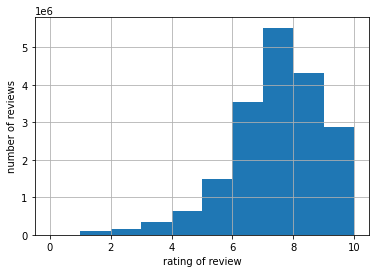

In [98]:
reviews['rating'].hist(bins=10)
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

As you can see,most of the reviews are between a 6 and a 10.

In [114]:
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count']).sort_values('mean',ascending=False)
games_by_all_users['rank']=games_by_all_users.reset_index().index+1
games_by_all_users.sort_values('count', ascending=False, inplace=True)
print(len(games_by_all_users))

games_by_all_users = games_by_all_users.merge(games[['name','Geekscore']],how='left',left_on=['name'], right_on=['name'])
games_by_all_users.head()

21440


,name,mean,count,rank,Geekscore
0,Pandemic,7.594996,108971,2046,7.487
1,Carcassonne,7.416162,108881,2892,7.308
2,Catan,7.133179,108195,4705,6.970
3,7 Wonders,7.733539,90110,1521,7.634
4,Dominion,7.607675,81623,2001,7.499


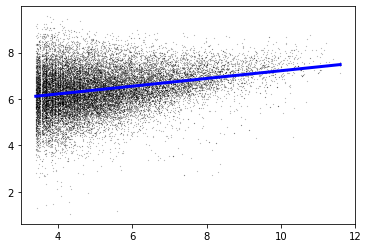

In [178]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = games_by_all_users['logcount'].values.reshape(-1, 1)
y = games_by_all_users['mean']

regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black',s=0.01)
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.show()

In [182]:
totalmean = y.mean()

In [183]:
penalties = totalmean - regr.predict(x)

In [187]:
games_by_all_users['penalty'] = penalties
games_by_all_users['adjmean'] = games_by_all_users['mean'] + penalties

In [193]:
games_by_all_users.sort_values('adjmean', ascending=False, inplace=True)
games_by_all_users.loc[games_by_all_users['count']>2000][:20]

,name,mean,count,rank,Geekscore,logcount,adjmean,penalty
1688,Too Many Bones: Undertow,8.745965,2105,82,7.201,7.652071,8.339432,-0.406532
1256,Kanban EV,8.616204,2968,142,7.434,7.995644,8.152427,-0.463777
776,Clank!: Legacy – Acquisitions Incorporated,8.697162,4973,104,7.844,8.511779,8.147388,-0.549773
1046,Pandemic Legacy: Season 0,8.633607,3615,131,7.583,8.192847,8.136972,-0.496634
711,Eclipse: Second Dawn for the Galaxy,8.674057,5438,117,7.801,8.601167,8.109390,-0.564667
1280,Sleeping Gods,8.504350,2917,194,7.313,7.978311,8.043460,-0.460889
1264,The Crew: Mission Deep Sea,8.455332,2950,223,7.337,7.989560,7.992569,-0.462764
498,Kingdom Death: Monster,8.604285,8081,151,7.733,8.997271,7.973621,-0.630664
1348,Mythic Battles: Pantheon,8.422332,2762,254,7.082,7.923710,7.970540,-0.451792
219,Gloomhaven: Jaws of the Lion,8.678611,16072,116,8.261,9.684834,7.933388,-0.745223


In [168]:
games_by_all_users['logcount'] = np.log(games_by_all_users['count'])

In [169]:
games_by_all_users

,name,mean,count,rank,Geekscore,logcount
0,Pandemic,7.594996,108971,2046,7.487,11.598837
1,Carcassonne,7.416162,108881,2892,7.308,11.598011
2,Catan,7.133179,108195,4705,6.970,11.591690
3,7 Wonders,7.733539,90110,1521,7.634,11.408786
4,Dominion,7.607675,81623,2001,7.499,11.309866
...,...,...,...,...,...,...
21834,Fish & Ships,5.790000,30,16429,5.504,3.401197
21835,Invasion Afghanistan: The Soviet-Afghan War 19...,7.308333,30,3520,5.526,3.401197
21836,Ruck Zuck,6.062667,30,14366,5.508,3.401197
21837,Maailmatrivia,5.666667,30,17288,5.502,3.401197


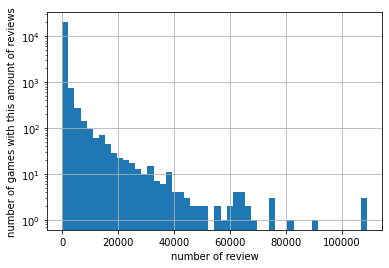

In [103]:
games_by_all_users['count'].hist(bins=50)
plt.xlabel('number of review')
plt.yscale('log')
plt.ylabel('number of games with this amount of reviews')
plt.show()

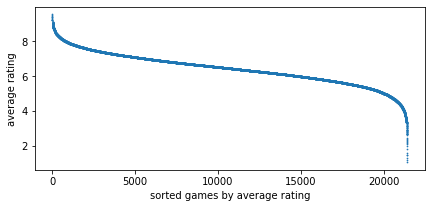

In [66]:
x = games_by_all_users['rank']
y = games_by_all_users['mean']
# y2 = games_by_all_users['Geekscore']
plt.figure(num=None, figsize=(7, 3), facecolor='w', edgecolor='k')
plt.scatter(x, y,s=0.5)
# plt.scatter(x, y2,s=0.5)
plt.xlabel('sorted games by average rating')
plt.ylabel('average rating')
plt.show()  # or plt.savefig("name.png")

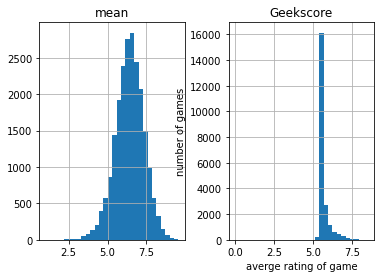

In [35]:
games_by_all_users[['mean','Geekscore']].hist(bins=30)
plt.xlabel('averge rating of game')
plt.ylabel('number of games')
plt.show()

If we compute the average rating of the games, it's even more visible that the ratings are really centered around the mean which is 6.4. The Geekscore is a score which penalizes games when they have few reviews, since the uncertainty around their 'true' score is higher. This is reflected in a lower average score of 5.6 and a lower standard deviation (0.92 vs 0.36 is a pretty large difference)

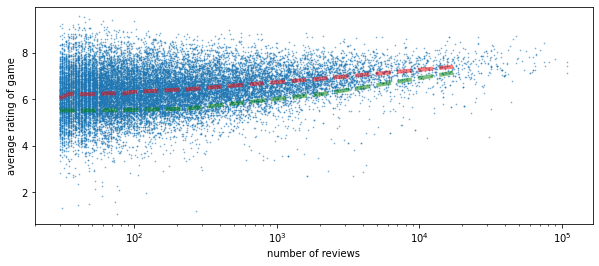

In [11]:
x = games_by_all_users['count']
y = games_by_all_users['Geekscore']
y2 = games_by_all_users['mean']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000,10000,100000])           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin


df2 = pd.DataFrame({'X' : x, 'Y' : y2})  #we build a dataframe from the data
data_cut = pd.cut(df2.X,bins=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000,10000,100000])           #we cut the data following the bins
grp = df2.groupby(by = data_cut)        #we group the data by the cut
ret2 = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df2.X,df2.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.plot(ret2.X,ret2.Y,'r--',lw=4,alpha=0.5)
plt.xlabel('number of reviews')
plt.ylabel('average rating of game')
plt.show()

Plotted on a logaritmic scale, obviously most of the games don't have that many reviews. There appears to be a slight positive correlation between the amount of reviews and the average score. The red score marks the average score, the green the 'Geekscore', which again penalizes for a lower amount of ratings. 

In [12]:
reviews_by_user_count = reviews.groupby('user')['rating'].agg(['mean','count']).sort_values('count',ascending=False).reset_index()
print(len(reviews_by_user_count))
reviews_by_user_count.head()

412815


,user,mean,count
0,oldgoat3769967,6.185752,6471
1,warta,7.230800,6289
2,leffe dubbel,5.937541,6068
3,TomVasel,6.401869,5672
4,Doel,7.496200,5131


Oldgoat and warta are newcomers and where not in the top 5 a couple of years ago. 6471 games reviewed, that is a lot!

Text(0, 0.5, 'number of reviews written')

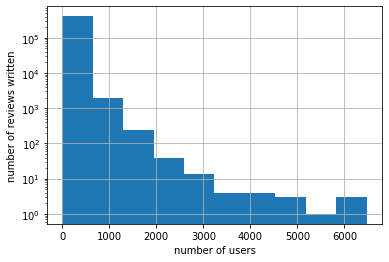

In [36]:
reviews_by_user_count['count'].hist(log=True)
plt.xlabel('number of users')
plt.ylabel('number of reviews written')

Most of the users have between 0-500 reviews, however there are some enthusiasts with >5000 reviews! That's some real dedication right there!

In [37]:
# select users that reviewed more than cutoff games
cutoff = 500
active_users = reviews_by_user_count[reviews_by_user_count['count']>cutoff]
active_users = active_users['user']
reviews_by_active_users = reviews[reviews['user'].isin(active_users)]
print(len(reviews_by_active_users))
reviews_by_active_users.head()

3243140


,user,rating,comment,ID,name
0,Torsten,10.0,NaN,30549,Pandemic
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,Mike Mayer,10.0,NaN,30549,Pandemic
5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
13,PopeBrain,10.0,(25+ plays) Who can play? Family game for ...,30549,Pandemic


In [38]:
count_user, count_review = reviews[['user','name']].nunique()
print('density',len(reviews)/(count_user*count_review))
count_user, count_review = reviews_by_active_users[['user','name']].nunique()
print('density', len(reviews_by_active_users)/(count_user*count_review))

density 0.002142733585985266
density 0.0374518955037678


In [149]:
# as a cutoff I take 500 reviews, then you have 90% of the games into account
comparison = pd.merge(games_by_all_users, games_rated_by_active_users, on='name', suffixes=('all', 'active'))
comparison['delta active - all'] = comparison['meanactive'] - comparison['meanall']
comparison = comparison.loc[comparison['countall']>500, :].copy()
comparison.sort_values('rankactive', ascending=True, inplace=True)
comparison[:20]

,name,meanall,countall,rankall,Geekscore,meanactive,countactive,rankactive,delta active - all
4169,Aeon's End: Outcasts,8.758231,633,79,6.336,8.492899,69,53,-0.265332
3609,Great Western Trail (Second Edition),8.586943,781,160,6.422,8.372021,97,81,-0.214923
1046,Pandemic Legacy: Season 0,8.633607,3615,131,7.583,8.284986,432,111,-0.348621
1264,The Crew: Mission Deep Sea,8.455332,2950,223,7.337,8.246292,617,132,-0.209040
4552,Sherlock Holmes Consulting Detective: The Bake...,8.525073,558,184,6.205,8.236953,64,134,-0.288120
4531,1817,8.689767,563,108,6.294,8.197518,141,152,-0.492250
2115,Ark Nova,8.700605,1630,101,6.976,8.194843,291,155,-0.505762
776,Clank!: Legacy – Acquisitions Incorporated,8.697162,4973,104,7.844,8.141282,563,180,-0.555879
30,Pandemic Legacy: Season 1,8.591016,45118,157,8.442,8.137756,2315,183,-0.453261
109,Brass: Birmingham,8.661637,25583,126,8.419,8.134055,1710,185,-0.527581


In [16]:
games_rated_by_active_users = reviews_by_active_users.groupby('name')['rating'].agg(['mean','count']).sort_values('mean',ascending=False)
games_rated_by_active_users['rank']=games_rated_by_active_users.reset_index().index+1

print('{} users original, with {} reviews'.format(reviews['user'].nunique(),len(reviews)))
print('{} users left({}% of the userbase), with {} reviews (this is {} of all reviews)'.format(len(active_users),len(active_users)/reviews['user'].nunique(),len(reviews_by_active_users),len(reviews_by_active_users)/len(reviews)))

412815 users original, with 18964807 reviews
4048 users left(0.009805845233336967% of the userbase), with 3243140 reviews (this is 0.17100833137927532 of all reviews)


<AxesSubplot:>

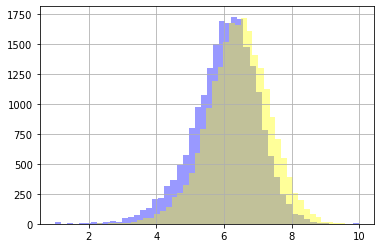

In [71]:
games_rated_by_active_users['mean'].hist(bins=50, fc=(0, 0, 1, 0.4))
games_by_all_users['mean'].hist(bins=50, fc=(1, 1, 0, 0.4))

Games seem to get a slightly higher shore when rated by all users

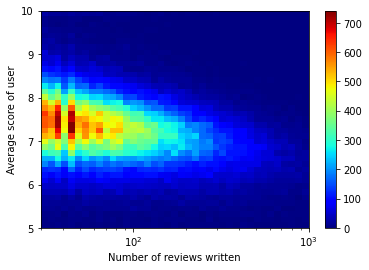

In [18]:
x = reviews_by_user_count['count']
y = reviews_by_user_count['mean']
plt.xscale('log')

plt.hist2d(x, y, bins=[np.logspace(np.log10(30),np.log10(1000),40),np.linspace(5,10,num=40)], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('Number of reviews written')
plt.ylabel('Average score of user')
plt.show()

This graph shows that users with many reviews tend to give lower scores compared to users that are less active (r2=0.09). Two explainations arise:
- Active users simply rate more games, so they also play more bad games. Vice versa, casual users just play good games
- Active users are more critical of games, so tend to give lower scores

In [19]:
merge = games_rated_by_active_users[['mean','count']].merge(games_by_all_users[['name','mean','count', 'Geekscore']],how='outer',left_index=True, right_on=['name'],suffixes=('active','all'),indicator=True)

merge['delta_active_all']=merge['meanactive']-merge['meanall']
merge['proportion_active']=merge['countactive']/merge['countall']
merge.sort_values('countall',ascending=False)[:5]

,meanactive,countactive,name,meanall,countall,Geekscore,_merge,delta_active_all,proportion_active
2063,7.185200,3784.0,Pandemic,7.594996,108971,7.487,both,-0.409796,0.034725
2917,7.041695,3767.0,Carcassonne,7.416162,108881,7.308,both,-0.374467,0.034597
4758,6.633279,3692.0,Catan,7.133179,108195,6.970,both,-0.499899,0.034124
1534,7.433874,3830.0,7 Wonders,7.733539,90110,7.634,both,-0.299666,0.042504
2018,7.338173,3732.0,Dominion,7.607675,81623,7.499,both,-0.269502,0.045722


In [20]:
merge['delta_active_all'].median()

-0.32408600490196093

The active users with >500 reviews per user make up 1% of the userbase, but almost submit 15% of all the reviews. Their scores per game are about 0.33 points lower compared to the whole population. To me this suggests they are more critical, since we are comparing per game. E.g. Catan has a mean score of 7.21 (meanall), but a mean score of 6.79 by the active users, leading to a delta of 0.43 (delta_active_all). Furthermore, the reviews of active users make up 3% of the reviews for Catan (proportion_active)

In [21]:
corr = merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,meanactive,countactive,meanall,countall,Geekscore,delta_active_all,proportion_active
meanactive,1.000000,0.215010,0.879693,0.154270,0.440991,0.331588,-0.084813
countactive,0.215010,1.000000,0.209048,0.840880,0.767817,0.031804,-0.114385
meanall,0.879693,0.209048,1.000000,0.168738,0.467709,-0.156943,-0.262062
countall,0.154270,0.840880,0.168738,1.000000,0.612569,-0.016466,-0.182841
Geekscore,0.440991,0.767817,0.467709,0.612569,1.000000,-0.017104,-0.212778
delta_active_all,0.331588,0.031804,-0.156943,-0.016466,-0.017104,1.000000,0.343761
proportion_active,-0.084813,-0.114385,-0.262062,-0.182841,-0.212778,0.343761,1.000000


Aside from the obvious correlations between the set of reviews by active users and all reviews, a few things stand out:
- The geekscore has a higher correlation with the number of reviews (count) than the average score given (mean). Is this is problem?
- The more the reviews of games consist of active users, the lower the score (fairly low negative correlation)

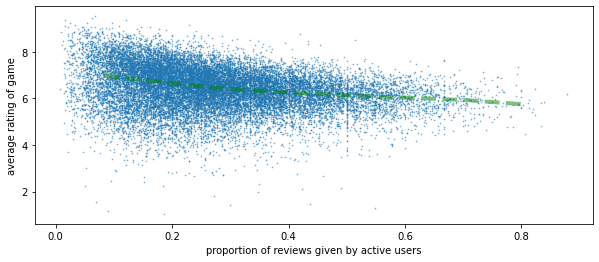

In [22]:
y = merge['meanall']
x = merge['proportion_active']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.linspace(0,1,num=10))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('proportion of reviews given by active users')
plt.ylabel('average rating of game')
plt.show()

Here you see the small effect that active users have on a lower average score of a game

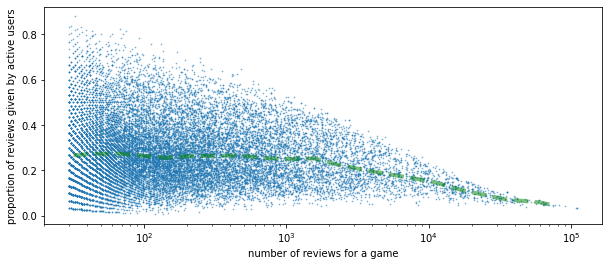

In [23]:
x = merge['countall']
y = merge['proportion_active']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,5,num=30))           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('number of reviews for a game')
plt.ylabel('proportion of reviews given by active users')
plt.show()

This makes sense, since games like Catan that have a huge number of reviews (85268) by majority are rated by casual users, since there are only about 2700 active users with >500 reviews.

A more 'clean' way to investigate this is to investigate per game how active it userbase is. How active users are can be defined by the mean number of reviews of the userbase.

In [24]:
merged_reviews = reviews.merge(reviews_by_user_count,how='left',on='user',suffixes=('','user'),indicator=True)
games_test = merged_reviews.groupby('name')[['rating','count']].agg(['mean','median','count']).sort_values(('count', 'count'),ascending=False)
games_test[:5]

rating                      count               
                 mean median   count        mean median   count
name                                                           
Pandemic     7.594996    8.0  108971  117.531931   60.0  108971
Carcassonne  7.416162    7.5  108881  116.488226   59.0  108880
Catan        7.133179    7.0  108195  112.098379   54.0  108194
7 Wonders    7.733539    8.0   90110  133.602242   72.0   90110
Dominion     7.607675    8.0   81623  136.728137   72.0   81622

Catan has a mean rating of 7.2, with median score of 7.0 and 84613 reviews. The users that reviewed it rated on average 105 games, with a median of 51.
The median is the best metric to gauge how active the users are, since it filters away the effect of extremely active users on the mean.

In [25]:
corr = games_test.corr()
corr.style.background_gradient(cmap='coolwarm')

Again, positive correlations for the number of reviews and scores, and negative correlations for the activity of the users that rated a game and the score

<AxesSubplot:>

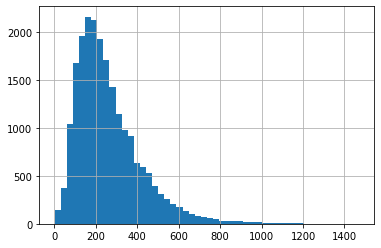

In [26]:
games_test['count','median'].hist(bins=50)

Nice distribution, lets investigate.

In [27]:
games_test = games_test.sort_values(('count', 'median'),ascending=True)
games_test[games_test['rating', 'count']>0][:30]

rating                    count         \
                                      mean median count        mean median   
name                                                                         
Clutch Baseball                   8.294355   9.00    62   64.419355    1.0   
Tomorrow Dies Today               9.056818  10.00    44  254.181818    1.0   
Composition                       9.108649  10.00    37  351.648649    1.0   
War Titans: Invaders Must Die!    9.241379  10.00    58   16.224138    1.0   
Crypto Cartel                     5.594595   8.00    37  144.459459    1.0   
Sheep in Disguise                 8.859375  10.00    32   21.968750    1.0   
Goblin Grapple                    8.202923   9.00   195  125.502564    1.0   
90°                               7.764706   9.00    51   66.941176    1.0   
Demon Espionage                   7.711111   8.00    45   68.955556    1.0   
Mage Noir                         8.780488   9.00    41  292.317073    1.0   
Thug Life the Game                9.071429  10.00    49   39.775510    1.0   
Feuding Foodies                   9.000000  10.00    40   15.225000    1.0   
Wild Life: The Card Game          8.840000   9.50    50  221.640000    1.0   
Drinks & Daggers                  9.041270  10.00    63   57.539683    1.0   
Ciudad de Cartón                  8.716216   9.00    37   80.729730    1.0   
Farts & Fairies                   8.040000   8.00    40   31.925000    1.0   
Gladiatoris                       9.227419   9.50    31  134.612903    1.0   
TerroriXico                       9.428571  10.00    70   21.671429    1.0   
Wizard Thieves                    8.464583   9.00    48  149.791667    1.0   
Flip & Fish                       9.136667   9.00    30  247.600000    1.0   
Animator vs Animation             9.062500  10.00    48    7.145833    1.0   
Hogs of War: The Miniatures Game  8.833333   9.00   120   46.291667    1.0   
El Dorado Canyon                  8.736000   9.00    30  238.600000    1.0   
Battle Gnomes                     8.628571  10.00    35   46.657143    1.0   
Frontier: The Card Game           8.189189  10.00    37  148.513514    2.0   
Wizardz Bluff                     8.312500   9.00    48  102.062500    2.0   
Malhya: Lands of Legends          9.568293  10.00    41   45.512195    2.0   
Urgency                           9.097561   9.00    41   48.560976    2.0   
Zaar                              7.871429   9.25    98   70.306122    2.5   
Welcome to Sysifus Corp           8.532353   8.65    34   29.264706    3.0   

                                        
                                 count  
name                                    
Clutch Baseball                     62  
Tomorrow Dies Today                 44  
Composition                         37  
War Titans: Invaders Must Die!      58  
Crypto Cartel                       37  
Sheep in Disguise                   32  
Goblin Grapple                     195  
90°                                 51  
Demon Espionage                     45  
Mage Noir                           41  
Thug Life the Game                  49  
Feuding Foodies                     40  
Wild Life: The Card Game            50  
Drinks & Daggers                    63  
Ciudad de Cartón                    37  
Farts & Fairies                     40  
Gladiatoris                         31  
TerroriXico                         70  
Wizard Thieves                      48  
Flip & Fish                         30  
Animator vs Animation               48  
Hogs of War: The Miniatures Game   120  
El Dorado Canyon                    30  
Battle Gnomes                       35  
Frontier: The Card Game             37  
Wizardz Bluff                       48  
Malhya: Lands of Legends            41  
Urgency                             41  
Zaar                                98  
Welcome to Sysifus Corp             34

The wall of shame: these games are all reviewed by users that are suspiciously inactive. Probably rated by fake accounts. But also not so many reviews. Kill the unicorns managed to get 200 though, with an median user that reviewed only 4 games.

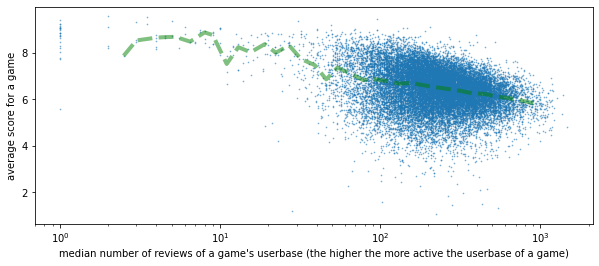

In [28]:
y = games_test[games_test['rating', 'count']>0]['rating', 'mean']
x = games_test[games_test['rating', 'count']>0]['count', 'median']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,3,num=40))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel("median number of reviews of a game's userbase (the higher the more active the userbase of a game)")
plt.ylabel('average score for a game')
plt.show()

The more active the userbase, the lower the average score a game receives.

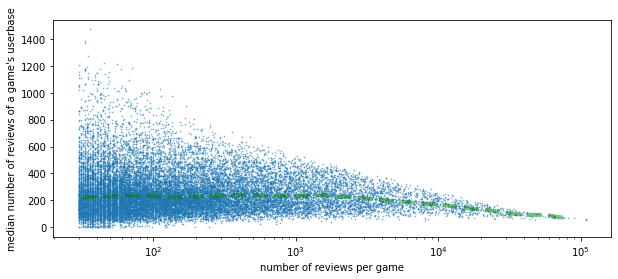

In [29]:
x = games_test['rating', 'count']
y = games_test['count', 'median']


df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,5,num=30))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('number of reviews per game')
plt.ylabel("median number of reviews of a game's userbase")
plt.show()

Here you see the effect again of games with a very high amount of ratings.

All in all, making causal inferences based on a historical data is like threading on thin ice. I do think experienced users give lower ratings, so are more critical. But concluding that games are ending up with a lower average rating because of these experienced reviewers is probably a step too far.

That's it. I enjoyed making my first dataset and kernel. Another interesting analysis would be the effect of time:
* are more recent scores higher
* are the first reviews games are getting higher or lower, are there patterns